In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore, linregress, spearmanr, pearsonr, false_discovery_control
import matplotlib.pyplot as plt
import mne
import nibabel as nib
from sklearn.decomposition import PCA

from mnitimescales import utils
from mnitimescales import plots

plots._set_font_params()

Imports and definitions:

In [3]:
stages = ["W", "N3", "R"]
stage_colors = {"W": "red", "N2": "cyan", "N3": "purple", "R": "green"}
title_dict = {"W": "Wake", "N2": "NREM2", "N3": "NREM3", "R": "REM"}
corr_type = "spearman"

# Paths
data_path = Path("F:\\MNIOpen")
tau_path = data_path.joinpath("Results", "timescales_broadband")
df_timescales_stages = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
tau_gamma_path = data_path.joinpath("Results", "timescales_gamma")
df_timescales_gamma_stages = {
    stage: pd.read_csv(tau_gamma_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


Format timescale dataframes:

In [4]:
# Prepare dataframe for plotting
df_broadband = deepcopy(df_timescales_stages)
df_gamma = deepcopy(df_timescales_gamma_stages)
for stage in stages:
    df_broadband[stage]["stage"] = stage
    df_gamma[stage]["stage"] = stage
df_broadband = pd.concat(df_broadband.values())
df_gamma = pd.concat(df_gamma.values())
df_broadband.rename(columns={"0": "tau"}, inplace=True)
df_gamma.rename(columns={"0": "tau"}, inplace=True)
df_broadband = df_broadband.pivot(columns="stage", values="tau")
df_gamma = df_gamma.pivot(columns="stage", values="tau")
df_broadband = df_broadband[stages]
df_gamma = df_gamma[stages]

Load structural data and the centroids coordinates of the parcellation (for spin permutation):

In [5]:
df_struct = pd.read_csv(data_path.joinpath("Data", "Raw", "df_structural_avg.csv"), index_col=0)
df_brain_genes = pd.read_csv(data_path.joinpath("Data", "Raw", "df_brain_genes.csv"), index_col=0)
df_genes = df_struct.iloc[:, 2:].copy()
# df_genes.columns = df_genes.columns.str.upper()
genes_brain = [gene for gene in df_brain_genes["symbol"].values if gene in df_genes.columns]
df_genes_brain = df_genes[genes_brain]
map_coords = pd.read_csv(data_path.joinpath("Data", "Parcellation", "mmp_centroids_coords.csv"), index_col=0)

In [6]:
df_genes_brain

,S1PR5,GAP43,PRMT8,SCN2A,NME5,RGS7BP,B4GAT1,P2RY12,C1QL3,SRGAP3,...,GRIK3,PHKG1,TBC1D24,PTPRO,DYNC1I1,B3GALT1,PRSS35,PCDHA9,TINAG,MCHR1
V1,-0.818235,-3.957000,0.609985,-1.453350,0.816665,-0.759510,-3.322150,-1.991050,-3.805600,0.980365,...,-0.943175,-2.198200,-2.365550,-2.690050,-2.824700,0.709230,-2.495950,1.907850,-1.080995,-2.819800
MST,-0.173410,-0.666790,-0.394925,-0.153436,0.281018,0.114270,-0.925155,-1.105225,-0.999695,0.856450,...,-0.270325,-0.719205,0.162810,-0.179390,-1.493150,-0.751010,-0.926945,0.969520,0.444810,-0.638140
V6,-0.752380,-1.418300,-0.324315,-0.283690,1.081590,-1.134900,-1.943300,-1.168700,-1.550600,0.598570,...,-0.634875,-1.920750,-1.285950,-1.087965,-1.543550,1.337450,-1.846300,1.475700,0.420280,-0.486345
V2,-0.633630,-3.310550,0.314811,-1.170185,0.862340,-0.749100,-3.046050,-1.773000,-3.089150,1.105830,...,-0.889400,-1.915900,-2.071000,-2.291800,-2.703550,0.859875,-2.283950,1.855300,-0.966575,-2.601100
V3,-0.537085,-2.414050,0.157856,-1.008855,1.106930,-0.625503,-2.590500,-1.478750,-2.448750,1.355550,...,-0.814695,-2.290600,-1.802000,-1.579140,-2.048350,0.726475,-2.246350,1.708200,-0.667535,-1.868785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STSva,0.083250,-0.391643,-0.275793,0.936800,-1.318800,-0.385475,0.637745,1.398700,0.971850,-0.002100,...,0.414640,-0.032410,0.341585,0.990270,0.728080,-0.315910,0.455130,-0.916730,0.554955,0.606525
TE1m,-0.669445,0.503860,-0.159880,1.203900,-0.208565,-0.404865,0.987295,0.995425,0.975300,0.213135,...,0.511815,-0.440193,0.130755,0.983690,1.274925,0.054460,0.441360,-1.119460,0.778955,0.094780
PI,-0.311250,0.128115,0.063440,0.937165,-1.086970,-0.162810,1.240975,1.413550,0.905515,0.115236,...,0.352905,0.416815,1.387850,1.547950,0.793780,-0.656435,1.300850,-0.440685,-0.115015,0.476945
a32pr,1.199615,1.248175,0.397330,-0.254910,-1.293300,-0.240390,1.512500,0.930480,1.463900,-2.026950,...,0.829210,2.065700,1.081015,0.300900,0.642690,-0.401780,1.864350,-0.384176,-0.411340,0.666935


### Compute PCs of gene expression:

In [7]:
n_pcs = 10
X = df_genes_brain
pca = PCA(n_components=n_pcs, random_state=42)
gene_grad = pca.fit_transform(X.to_numpy())
df_pc_weights = pd.DataFrame(pca.components_.T, index=X.columns, columns=['pc%i'%i for i in range(1, n_pcs + 1)])
df_pc_weights

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
S1PR5,0.012253,-0.005392,0.034612,0.011005,-0.019547,-0.028468,-0.021645,-0.004506,-0.038643,0.004264
GAP43,-0.019435,-0.023697,0.022946,-0.034390,-0.003635,0.028105,-0.004506,0.009137,-0.000118,0.021110
PRMT8,-0.003685,-0.043047,0.003534,-0.015783,-0.003366,-0.000237,0.014823,-0.004198,0.034533,0.008310
SCN2A,-0.018421,-0.013059,-0.037734,0.003904,0.009046,0.035433,-0.010637,-0.008575,-0.020476,0.011505
NME5,0.022320,0.009581,-0.002288,-0.024842,-0.002851,0.034777,-0.011984,0.031967,0.000926,0.000945
...,...,...,...,...,...,...,...,...,...,...
B3GALT1,0.008738,0.022129,-0.011439,0.002923,0.053743,0.018166,-0.018640,0.005418,-0.023801,-0.025982
PRSS35,-0.034759,-0.003083,0.000179,-0.014454,0.006446,-0.006787,0.000657,-0.009077,-0.002507,-0.005734
PCDHA9,0.021261,0.000460,-0.027115,-0.034272,-0.024954,-0.018684,0.021207,-0.012622,0.005404,-0.016487
TINAG,0.005060,-0.022266,-0.031751,-0.026516,-0.002556,0.012217,-0.027674,-0.025581,-0.033148,-0.030195


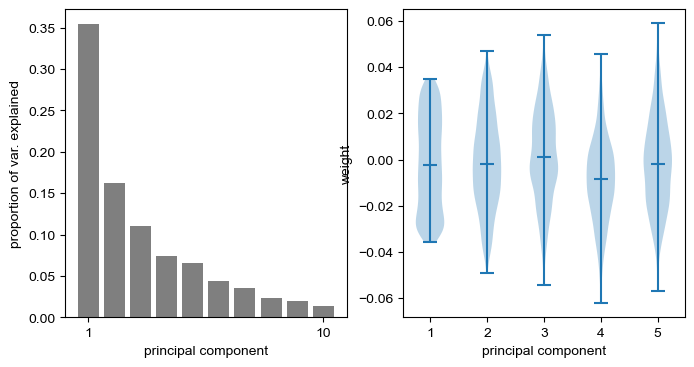

In [8]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.bar(range(1,n_pcs+1), pca.explained_variance_ratio_, fc='k', alpha=0.5)
plt.xticks([1, 10], ['1', '10']);
plt.xlabel('principal component'); plt.ylabel('proportion of var. explained');

plt.subplot(1,2,2)
plt.violinplot(pca.components_[:5,:].T, showmedians=True, showextrema=True)
plt.xlabel('principal component'); plt.ylabel('weight')

plt.show()


In [9]:
np.cumsum(pca.explained_variance_ratio_)

array([0.35426934, 0.51590503, 0.62576516, 0.70012608, 0.76598687,
       0.81008779, 0.84571483, 0.86872152, 0.88831128, 0.9018282 ])

Check reproducibility with Gao:

In [10]:
df_gao = pd.read_csv(data_path.joinpath("Gao2020", "df_tau_avg.csv"), index_col=0)

df_res_gao = pd.DataFrame(index=range(1, 6), columns=["rho", "p_corr"])

# for i, stage in enumerate(stages):
# Import dataframe

for pc in range(5):

    # Get data
    x = zscore(gene_grad[:, pc], ddof=1)
    y = df_gao.loc[df_struct.index, "logtau"].to_numpy().squeeze()
    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    # rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
    df_res_gao.loc[pc + 1] = rho, p_corr

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


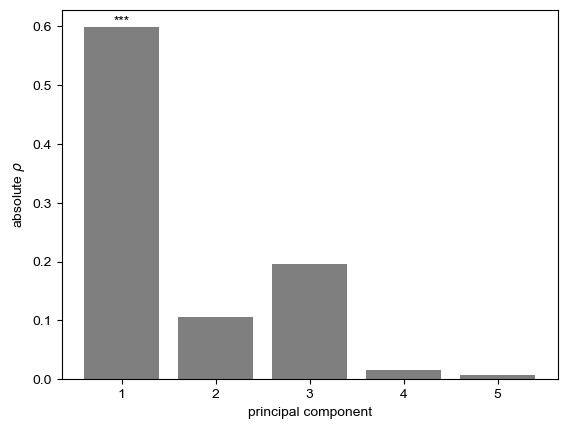

In [11]:
plt.bar(df_res_gao.index, np.abs(df_res_gao["rho"]), fc='k', alpha=0.5)
for i in range(1, 6): 
    p_str = ""
    p_str += "*" * sum(df_res_gao.loc[i, "p_corr"] < [0.05, 0.01, 0.005, 0.001]) 
    plt.annotate(p_str, (i, abs(df_res_gao.loc[i, "rho"]) + 0.005), horizontalalignment='center')
plt.xlabel('principal component'); plt.ylabel(r'absolute $\rho$');
plt.show()

Results with broadband / gamma:

In [19]:
df_res_broadband = pd.DataFrame(columns=["pc", "stage", "rho", "p_corr", "p_fdr"])
df_res_gamma = pd.DataFrame(columns=["pc", "stage", "rho", "p_corr", "p_fdr"])

for i, stage in enumerate(stages):
    # Import dataframe
    df_metric_broadband = df_broadband[stage].copy()
    df_metric_gamma = df_gamma[stage].copy()

    for pc in range(5):

        # Get data
        x = zscore(gene_grad[:, pc], ddof=1)
        y = df_metric_broadband.loc[df_struct.index].to_numpy().squeeze()
        # Get correlation values
        rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
        # rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
        df_res_broadband.loc[5*i + pc, "pc"] = pc + 1
        df_res_broadband.loc[5*i + pc, "stage"] = stage
        df_res_broadband.loc[5*i + pc, "rho"] = rho
        df_res_broadband.loc[5*i + pc, "p_corr"] = p_corr

        # Get data
        y = df_metric_gamma.loc[df_struct.index].to_numpy().squeeze()
        # Get correlation values
        rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
        # rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
        df_res_gamma.loc[5*i + pc, "pc"] = pc + 1
        df_res_gamma.loc[5*i + pc, "stage"] = stage
        df_res_gamma.loc[5*i + pc, "rho"] = rho
        df_res_gamma.loc[5*i + pc, "p_corr"] = p_corr

df_res_broadband["p_fdr"] = false_discovery_control(df_res_broadband["p_corr"].to_numpy(float))
df_res_gamma["p_fdr"] = false_discovery_control(df_res_gamma["p_corr"].to_numpy(float))

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


In [32]:
df_res_broadband[df_res_broadband["p_corr"] < 0.05]

,pc,stage,rho,p_corr,p_fdr
0,1,W,-0.477206,0.0,0.332143
5,1,N3,-0.293371,0.039,0.581250
6,2,N3,-0.329619,0.028,0.332143
12,3,R,-0.484854,0.012,0.150000


In [33]:
df_res_gamma[df_res_gamma["p_corr"] < 0.05]

,pc,stage,rho,p_corr,p_fdr
5,1,N3,0.725741,0.0,0.000
10,1,R,0.615714,0.0,0.015


### Control for "confounding" with T1w/T2w:

In [23]:
def get_residuals(x, y, z):

    data = pd.DataFrame(np.c_[x, y ,z], columns=["x", "y", "z"])
    data_ranks = data.copy().rank()
    result_xz = linregress(data_ranks["z"], data_ranks["x"])
    resid_xz = data_ranks["x"] - (result_xz.intercept + result_xz.slope * data_ranks["z"])
    result_yz = linregress(data_ranks["z"], data_ranks["y"])
    resid_yz  =data_ranks["y"] - (result_yz.intercept + result_yz.slope * data_ranks["z"])

    return resid_xz, resid_yz
    

In [27]:
df_res_broadband_corr = pd.DataFrame(columns=["pc", "stage", "rho", "p_corr", "p_fdr"])
df_res_gamma_corr = pd.DataFrame(columns=["pc", "stage", "rho", "p_corr", "p_fdr"])


for i, stage in enumerate(stages):
    # Import dataframe
    df_metric_broadband = df_broadband[stage].copy()
    df_metric_gamma = df_gamma[stage].copy()

    y_bb = df_metric_broadband.loc[df_struct.index].to_numpy().squeeze()
    y_gamma = df_metric_gamma.loc[df_struct.index].to_numpy().squeeze()

    z = zscore(df_struct["T1T2"], ddof=1).to_numpy()


    for pc in range(5):

        # Get gene PC
        x = zscore(gene_grad[:, pc], ddof=1)

        # Broadband
        # Get residuals and do correlation
        resid_xz, resid_yz = get_residuals(x, y_bb, z)
        rho, p_corr = utils.get_pcorr(resid_xz, resid_yz, map_coords, method="vasa", corr_type="pearson")
        # Add to df
        df_res_broadband_corr.loc[5*i + pc, "pc"] = pc + 1
        df_res_broadband_corr.loc[5*i + pc, "stage"] = stage
        df_res_broadband_corr.loc[5*i + pc, "rho"] = rho
        df_res_broadband_corr.loc[5*i + pc, "p_corr"] = p_corr

        # Gamma
        # Get residuals and do correlation
        resid_xz, resid_yz = get_residuals(x, y_gamma, z)
        rho, p_corr = utils.get_pcorr(resid_xz, resid_yz, map_coords, method="vasa", corr_type="pearson")
        # Add to df
        df_res_gamma_corr.loc[5*i + pc, "pc"] = pc + 1
        df_res_gamma_corr.loc[5*i + pc, "stage"] = stage
        df_res_gamma_corr.loc[5*i + pc, "rho"] = rho
        df_res_gamma_corr.loc[5*i + pc, "p_corr"] = p_corr

df_res_broadband_corr["p_fdr"] = false_discovery_control(df_res_broadband_corr["p_corr"].to_numpy(float))
df_res_gamma_corr["p_fdr"] = false_discovery_control(df_res_gamma_corr["p_corr"].to_numpy(float))

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


In [35]:
df_res_broadband_corr[df_res_broadband_corr["p_corr"] < 0.05]

,pc,stage,rho,p_corr,p_fdr
12,3,R,-0.485735,0.01,0.15


In [36]:
df_res_gamma_corr[df_res_gamma_corr["p_corr"] < 0.05]

,pc,stage,rho,p_corr,p_fdr
5,1,N3,0.536511,0.0,0.000
10,1,R,0.356377,0.002,0.015


It is interesting that the removal of the T1w/T2w "confounding" factor reveals richer patterns than in the "non corrected" analysis, especially in gamma.

In [45]:
fig, ax = plots.plot_parcellated_metric(
    zscore(gene_grad[:, 0], ddof=1).squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=[-2, 2],
    title="",
    cmap="viridis",
    label="PC 1",
    cbar_format="0f",
)

fig.savefig(
    data_path.joinpath("Figures", f"test_genes_pc_1.svg"),
    format="svg",
    transparent=True,
)
plt.close(fig)

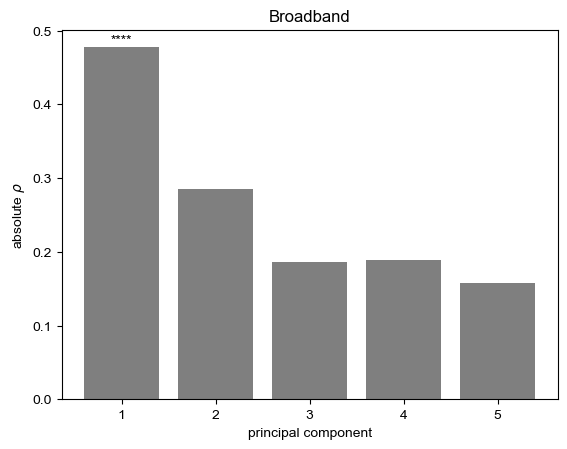

In [70]:
plt.bar(df_res_broadband.index, np.abs(df_res_broadband["rho"]), fc='k', alpha=0.5)
for i in range(1, 6): 
    p_str = ""
    p_str += "*" * sum(df_res_broadband.loc[i, "p_corr"] < [0.05, 0.01, 0.005, 0.001]) 
    plt.annotate(p_str, (i, abs(df_res_broadband.loc[i, "rho"]) + 0.005), horizontalalignment='center')
plt.xlabel('principal component')
plt.ylabel(r'absolute $\rho$')
plt.title("Broadband")
plt.show()

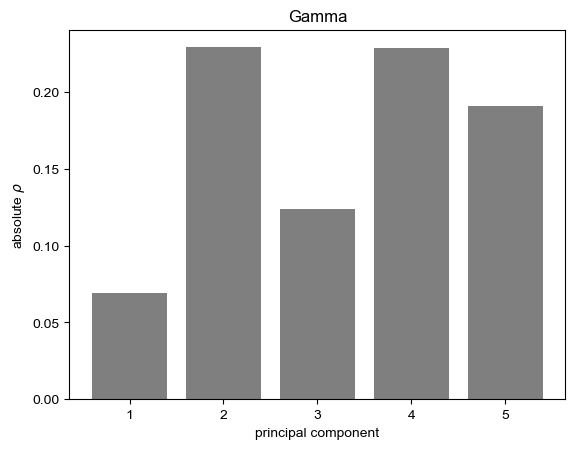

In [71]:
plt.bar(df_res_gamma.index, np.abs(df_res_gamma["rho"]), fc='k', alpha=0.5)
for i in range(1, 6): 
    p_str = ""
    p_str += "*" * sum(df_res_gamma.loc[i, "p_corr"] < [0.05, 0.01, 0.005, 0.001]) 
    plt.annotate(p_str, (i, abs(df_res_gamma.loc[i, "rho"]) + 0.005), horizontalalignment='center')
plt.xlabel('principal component')
plt.ylabel(r'absolute $\rho$')
plt.title("Gamma")
plt.show()

In [72]:
df_res_gamma

,rho,p_corr
1,0.069502,0.693
2,0.229071,0.282
3,0.124037,0.485
4,0.228318,0.196
5,-0.190924,0.287


Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


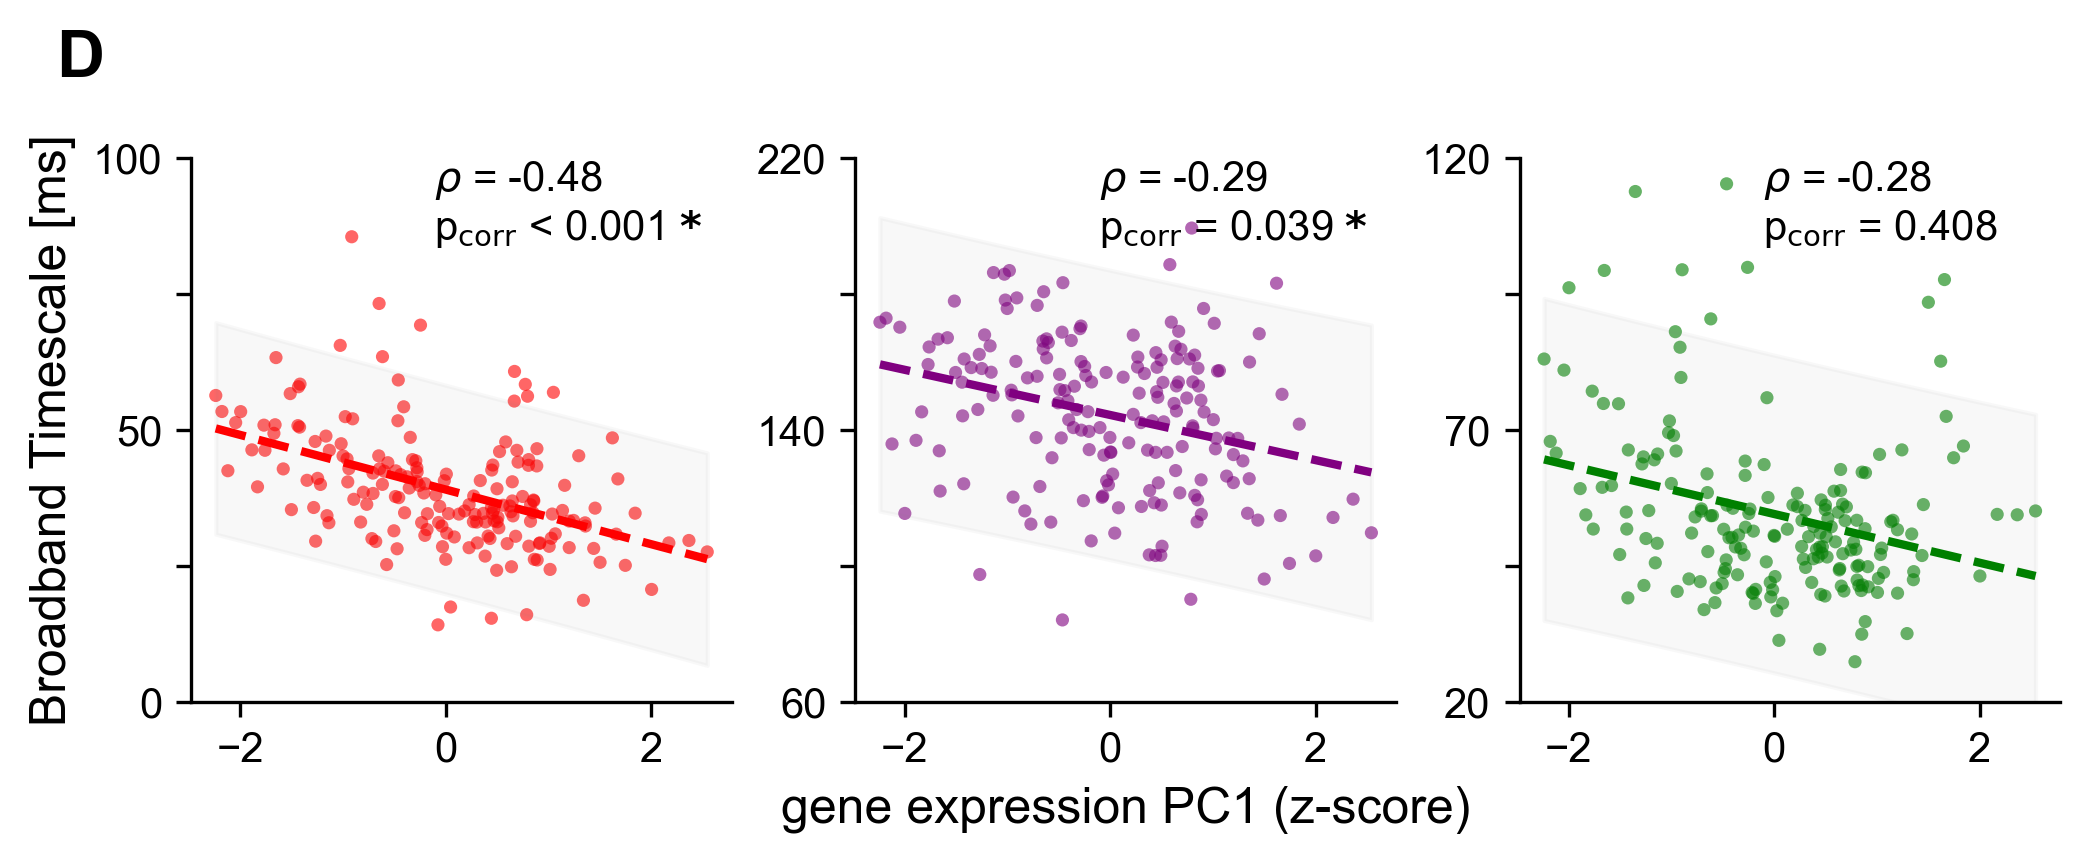

In [42]:
xlabel = "gene expression PC1 (z-score)"
ylabel = "Broadband Timescale [ms]"
# xlims = (-2.2, 4)
# xticks = [-2, 0, 2, 4]
xtick_labels = [-2, 0, 2, 4]
ylims_stages = {"W": (0, 100), "N2": (45, 125), "N3": (60, 220), "R": (20, 120)}
yticks = (
    np.arange(0, 101, 25),
    np.arange(60, 221, 40),
    np.arange(20, 121, 25)
    )
ytick_labels = (
    [0, "", 50, "", 100],
    [60, "", 140, "", 220],
    [20, "", 70, "", 120]
    )

fig, axs = plt.subplots(
    1, len(stages), figsize=plots._get_figsize_inches((17.4, 7)), dpi=300, layout="constrained"
)

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(stages):
    # Import dataframe
    df_metric = df_broadband[stage].copy()

    # Get data
    x = zscore(gene_grad[:, 0], ddof=1)
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=10,
        xy_annot=(0.45, 0.85),
        color=stage_colors[stage],
        xlabel="",
        ylabel="",
        # xlims=xlims,
        ylims=ylims_stages[stage],
    )
    
    # Set ticks
    # axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)
    plots._format_spines(axs[i]) #, s_bounds={"bottom": (-2, 4), "left": ylims_stages[stage]})

# Plot customization
axs[0].set_ylabel(ylabel, fontsize=plots.fsize.LABEL_SIZE)
axs[1].set_xlabel(xlabel, fontsize=plots.fsize.LABEL_SIZE)

# Annotate panel
axs[0].text(-0.25, 1.15, "D", transform=axs[0].transAxes, size=16, weight='bold')

# Save figure
# plots.save_figure(fig, fig_path.joinpath(f"tau_corr_struct.svg"))
plt.show()

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


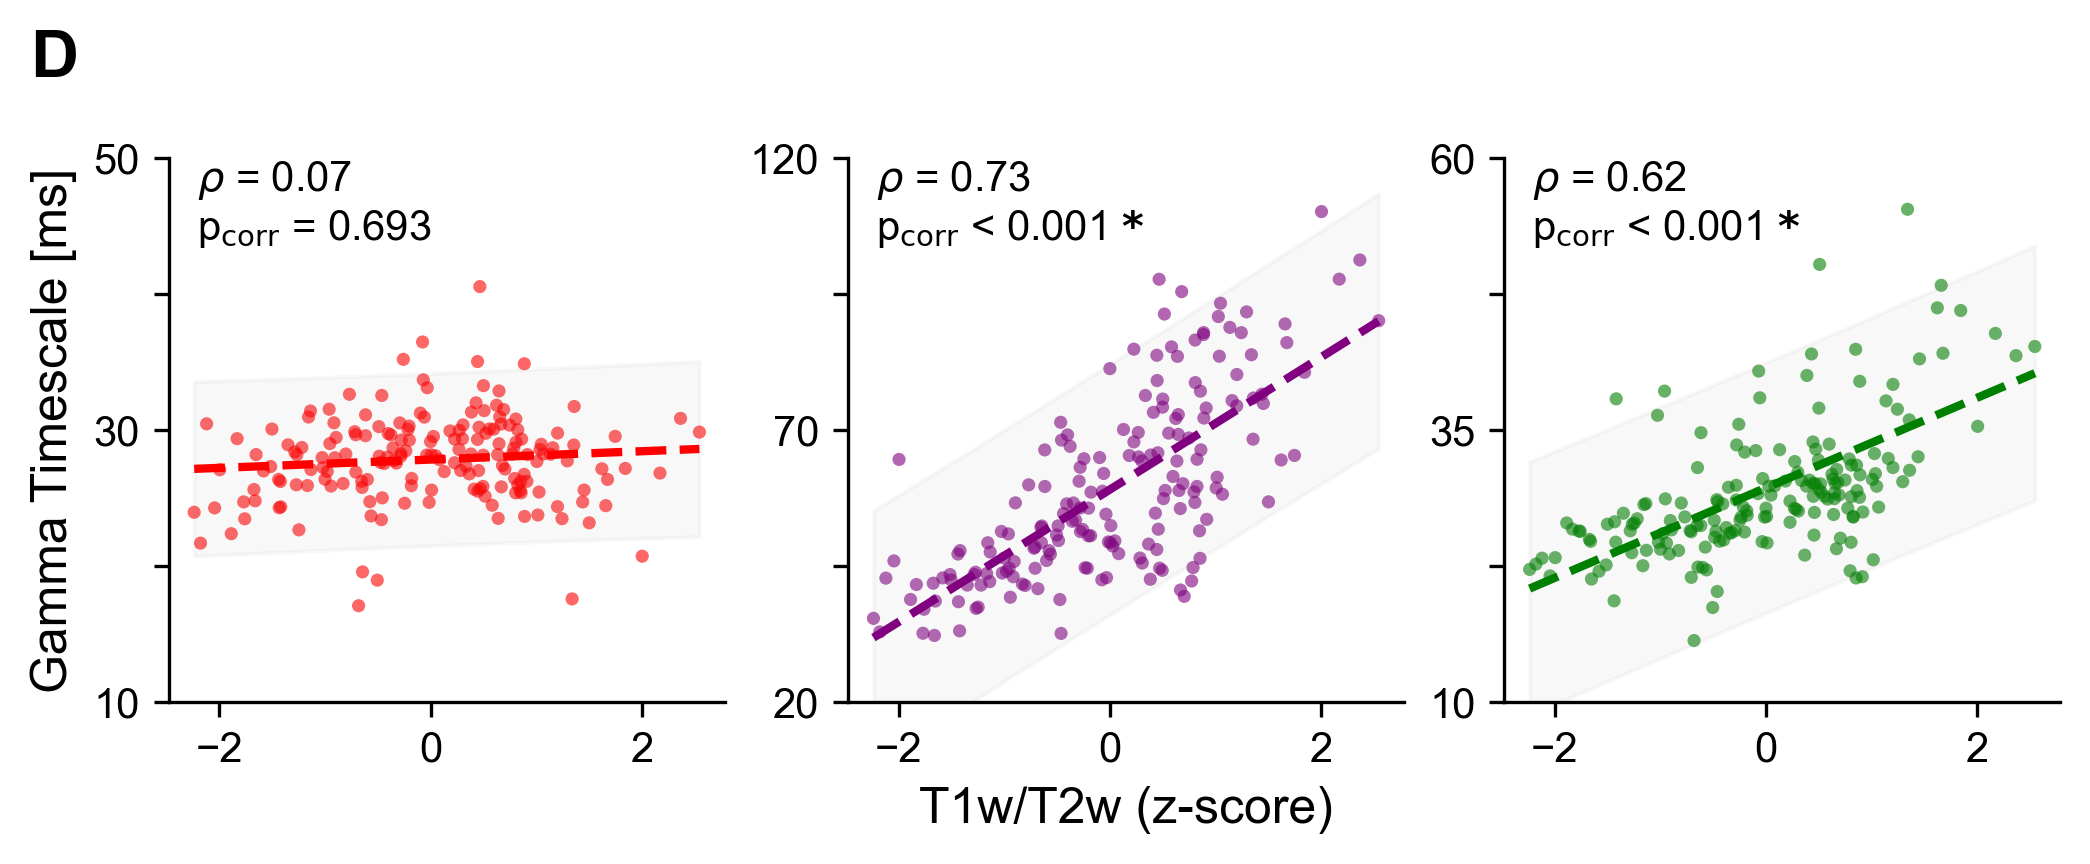

In [43]:
xlabel = "T1w/T2w (z-score)"
ylabel = "Gamma Timescale [ms]"
# xlims = (-2.2, 4)
# xticks = [-2, 0, 2, 4]
# xtick_labels = [-2, 0, 2, 4]
ylims_stages = {"W": (10, 50), "N2": (25, 65), "N3": (20, 120), "R": (10, 60)}
yticks = (
    np.arange(10, 51, 10),
    np.arange(20, 121, 25),
    np.arange(10, 61, 12.5)
    )
ytick_labels = (
    [10, "", 30, "", 50],
    [20, "", 70, "", 120],
    [10, "", 35, "", 60]
    )

fig, axs = plt.subplots(
    1, len(stages), figsize=plots._get_figsize_inches((17.4, 7)), dpi=300, layout="constrained"
)

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(stages):
    # Import dataframe
    df_metric = df_gamma[stage].copy()

    # Get data
    x = zscore(gene_grad[:, 0], ddof=1)
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=10,
        xy_annot=(0.05, 0.85),
        color=stage_colors[stage],
        xlabel="",
        ylabel="",
        # xlims=xlims,
        ylims=ylims_stages[stage],
    )
    
    # Set ticks
    # axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)
    plots._format_spines(axs[i]) #, s_bounds={"bottom": (-2, 4), "left": ylims_stages[stage]})

# Plot customization
axs[0].set_ylabel(ylabel, fontsize=plots.fsize.LABEL_SIZE)
axs[1].set_xlabel(xlabel, fontsize=plots.fsize.LABEL_SIZE)

# Annotate panel
axs[0].text(-0.25, 1.15, "D", transform=axs[0].transAxes, size=16, weight='bold')

# Save figure
# plots.save_figure(fig, fig_path.joinpath(f"tau_corr_struct.svg"))

plt.show()